# Fraudulent Transaction Detection

## Problem Statement
A financial company aims to detect fraudulent transactions using a machine learning model. The task is to identify fraudulent behavior patterns and provide actionable business insights with a dataset of over 6 million transactions.

## Business Objective
The primary aim of this project is to help a financial company identify and stop fraudulent transactions before they cause serious damage. To do this, we’ll build a machine learning model that can recognize suspicious patterns based on past transaction data.

## Dataset Overview:
Below is a brief description of features:
- >step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (31 days simulation).
- >type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- >amount - amount of the transaction in local currency.
- >nameOrig - customer who started the transaction
- >oldbalanceOrg - initial balance before the transaction
- >newbalanceOrig - new balance after the transaction
- >nameDest - customer who is the recipient of the transaction
- >oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- >newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- >isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- >isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than Rs 200,000 in a single transaction.

## Project Workflow
1. Importing libraries  
2. Loading the dataset  
3. Exploratory Data Analysis (EDA)  
4. Data preprocessing  
5. Feature engineering and selection  
6. Model development  
7. Model evaluation  
8. Model interpretability and insights 

## 1. Importing Libraries:

In [7]:
# Data Processing And Manipulation
import numpy as np
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing and Model Evaluation
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
classification_report,confusion_matrix,roc_auc_score,
roc_curve,accuracy_score,precision_score,recall_score,f1_score)
# Machine Learning models (Classification models)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
# Warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Loading the dataset

In [9]:
df=pd.read_csv('Fraud.csv')
# Displaying the first five rows:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Observation:
- Fraudulent transactions appear in `TRANSFER` and `CASH_OUT` types.
- The system failed to flag these frauds (`isFlaggedFraud = 0`) indicating gaps in rule-based detection.
- Even small transaction amounts can be fraudulent.
- Merchant accounts (IDs starting with "M") have zero or missing balance details.

## 3. Exploratory Data Analysis (EDA)

### (i) Initial data Overview:

In [13]:
# Basic structure of the dataset
print("Shape of Dataset:",df.shape)
print("\nColumn Names:\n",df.columns)

Shape of Dataset: (6362620, 11)

Column Names:
 Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


### Observation:
- The dataset contains **6,362,620 transactions** across **11 columns**.

In [15]:
# Checking the information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Observation:
- `nameOrig` and `nameDest` represent sender and receiver identifiers and are stored as string/object types.
- `type` is a **categorical variable** and will require **encoding** before modeling.

In [17]:
# Checking for missing values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Observation
- There are **no missing values** in any of the 11 columns.
- The dataset is **complete and ready for further preprocessing** without the need for imputation.

In [19]:
# Check for duplicate rows
df.duplicated().sum()

0

### Observation:
- No duplicate rows were found in the dataset.
- Each transaction entry is unique, indicating good data integrity.

In [21]:
# Count and ratio of fraud vs. non-fraud
df['isFraud'].value_counts()
df['isFraud'].value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

### Visulization of Class Imbalance:

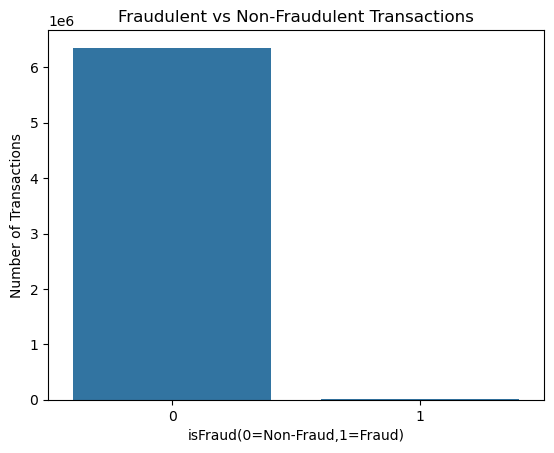

In [23]:
# Bar plot
sns.countplot(x='isFraud',data=df)
plt.title("Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("isFraud(0=Non-Fraud,1=Fraud)")
plt.ylabel("Number of Transactions")
plt.show()

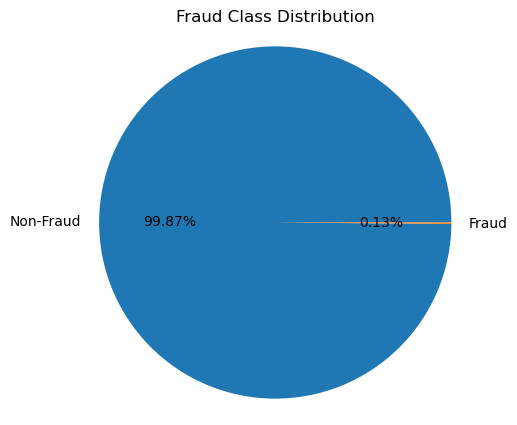

In [24]:
# Pie chart
labels=['Non-Fraud', 'Fraud']
sizes=df['isFraud'].value_counts()
plt.figure(figsize=(5,5))
plt.pie(sizes,labels=labels,autopct='%1.2f%%')
plt.title('Fraud Class Distribution')
plt.axis('equal')
plt.show()


### Observation:
- The dataset is **highly imbalanced**.
- Only **0.13%** of the transactions are labeled as fraud (`isFraud = 1`), while the remaining **99.87%** are legitimate (`isFraud = 0`).
- This imbalance indicates a need for careful model selection and the use of evaluation metrics like **Precision, Recall, F1-score**, and **ROC-AUC** rather than relying on Accuracy alone.

In [26]:
# Count of transaction types
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

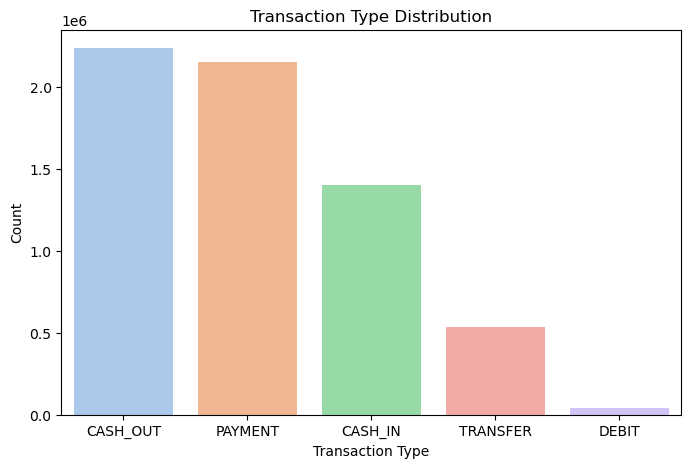

In [27]:
# Visualization of Transaction Type Distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df,x='type',order=df['type'].value_counts().index,palette='pastel')
plt.title("Transaction Type Distribution")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()

### Observation
- The most frequent transaction types are **CASH_OUT** and **PAYMENT**, each occurring over 2 million times.
- **CASH_IN** is the third most common type, followed by **TRANSFER**.
- **DEBIT** transactions are rare, with very few entries compared to other types.
- This imbalance in transaction type frequency should be considered during model training, especially for less common types like `DEBIT` and `TRANSFER`, which may be more associated with fraud.

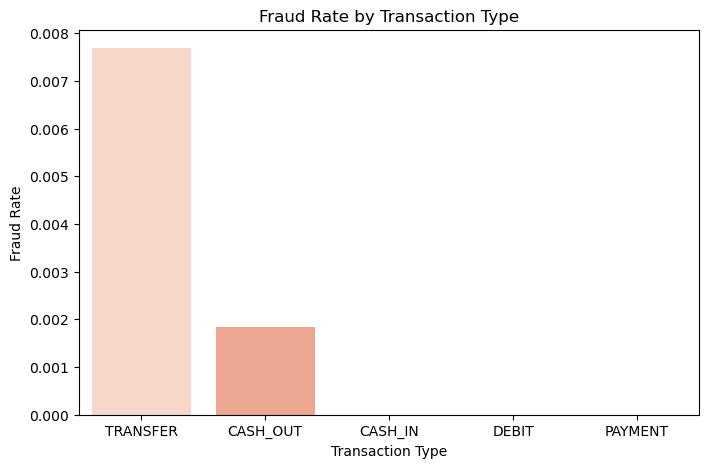

type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

In [29]:
# Fraud rate by type
fraud_rate_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=fraud_rate_by_type.index, y=fraud_rate_by_type.values, palette='Reds')
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate")
plt.xlabel("Transaction Type")
plt.show()
fraud_rate_by_type

### Observation
- **TRANSFER** transactions have the **highest fraud rate** at approximately **0.77%**, making them the most risky transaction type.
- **CASH_OUT** transactions follow with a fraud rate of about **0.18%**.
- **CASH_IN**, **DEBIT**, and **PAYMENT** transactions show a fraud rate of **0%**, indicating they are not targeted in this dataset.
- This insight is crucial for feature selection and model focus, as fraud is concentrated in only specific transaction types.

Since fraud only occurs in `TRANSFER` and `CASH_OUT` transactions, we retain only these two types to focus the model on meaningful patterns.

In [32]:
# Filter only relevant transaction types
df_filtered = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()
df_filtered.reset_index(drop=True, inplace=True)
# Verify result
df_filtered['type'].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

### Encode Transaction Type
The `type` column is categorical and must be converted into numeric format. We use one-hot encoding to create binary flags for each type.


In [34]:
# One-hot encode the 'type' column (drop_first avoids multicollinearity)
df_encoded=pd.get_dummies(df_filtered, columns=['type'], drop_first=True,dtype=int)
# Confirm new columns
df_encoded.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_TRANSFER
0,1,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,1
1,1,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,0
2,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0
3,1,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,1
4,1,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1


## Create Balance Error Features
To capture logical inconsistencies in balance transitions, we create:
- `errorOrig`: Difference between sender’s balance before and after, minus amount
- `errorDest`: Difference between recipient’s balance after and before, minus amount
These may help expose engineered fraud attempts.

In [36]:
df_encoded['errorOrig'] = df_encoded['oldbalanceOrg'] - df_encoded['amount'] - df_encoded['newbalanceOrig']
df_encoded['errorDest'] = df_encoded['newbalanceDest'] - df_encoded['oldbalanceDest'] - df_encoded['amount']
# Summary stats for new features
df_encoded[['errorOrig', 'errorDest']].describe()

,errorOrig,errorDest
count,2.770409e+06,2.770409e+06
mean,-2.859850e+05,2.864713e+04
std,8.753230e+05,5.934794e+05
min,-9.244552e+07,-1.000000e+07
25%,-2.798912e+05,-5.820766e-11
50%,-1.435971e+05,0.000000e+00
75%,-5.185310e+04,7.275958e-11
max,1.000000e-02,7.588573e+07


##  Outlier Detection and Removal using IQR
We'll remove extreme values in `amount`, `errorOrig`, and `errorDest` using the **Interquartile Range (IQR)**.

In [38]:
# IQR-based outlier removal function
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]
# Copy dataframe for outlier cleaning
df_cleaned = df_encoded.copy()
# Remove outliers from selected columns
for col in ['amount', 'errorOrig', 'errorDest']:
    df_cleaned = remove_outliers_iqr(df_cleaned, col)
# New shape after outlier removal
print("Shape after outlier removal:", df_cleaned.shape)

Shape after outlier removal: (1645415, 13)


## Define Feature Set and Target Variable
We now separate the input features and target column.


In [40]:
# Drop irrelevant columns and define X and y
X = df_cleaned.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = df_cleaned['isFraud']

## Train-Test Split and Scaling

Split the dataset with stratified sampling and apply feature scaling using `StandardScaler`.


In [42]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)
# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Model 1: Logistic Regression 

In [44]:
logreg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)
# Predictions
y_pred_log = logreg.predict(X_test_scaled)
y_prob_log = logreg.predict_proba(X_test_scaled)[:, 1]
# Evaluation
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_log).round(4))

Logistic Regression Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    410896
           1       0.02      1.00      0.03       458

    accuracy                           0.94    411354
   macro avg       0.51      0.97      0.50    411354
weighted avg       1.00      0.94      0.97    411354

Confusion Matrix:
 [[384272  26624]
 [     2    456]]
ROC-AUC Score: 0.9936


In [45]:
# isualization of Confusion matrix function:
def plot_conf_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

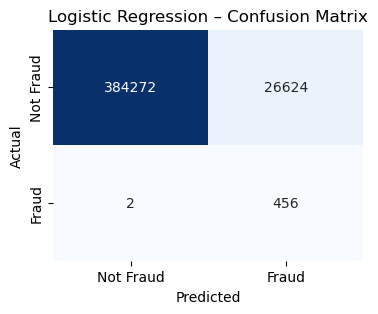

In [46]:
plot_conf_matrix(y_test, y_pred_log, title="Logistic Regression – Confusion Matrix")

## Observation:
- The model shows **very high recall (1.00)** for fraudulent transactions, meaning it successfully caught almost all actual fraud cases.
- However, the **precision for fraud (0.02)** is extremely low, which means it raised a large number of **false positives** — flagging many normal transactions as fraud.
- The **overall accuracy (94%)** and **ROC-AUC (0.9936)** are misleading due to severe class imbalance.
- This is typical behavior for logistic regression on imbalanced data — it tends to bias toward the majority class unless very carefully tuned or balanced.
- Confusion matrix confirms:
  - **True Negatives (TN)**: 384,272
  - **False Positives (FP)**: 26,624
  - **False Negatives (FN)**: 2
  - **True Positives (TP)**: 456

## Model 2: Decision Tree Classifier

In [49]:
dtree = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dtree.fit(X_train, y_train)

y_pred_dt = dtree.predict(X_test)
y_prob_dt = dtree.predict_proba(X_test)[:, 1]

# Evaluation
print("Decision Tree Report:")
print(classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_dt).round(4))


Decision Tree Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    410896
           1       0.99      1.00      0.99       458

    accuracy                           1.00    411354
   macro avg       0.99      1.00      1.00    411354
weighted avg       1.00      1.00      1.00    411354

Confusion Matrix:
 [[410891      5]
 [     1    457]]
ROC-AUC Score: 0.9989


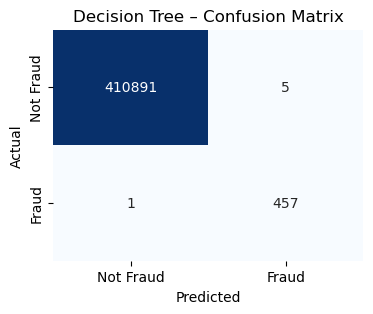

In [50]:
# Visualization Of confusion Matrix:
plot_conf_matrix(y_test, y_pred_dt, title="Decision Tree – Confusion Matrix")

## Observation:
- The model performed **exceptionally well** with an overall accuracy of **100%** and **ROC-AUC of 0.9989**, indicating near-perfect classification.
- It achieved:
  - **Precision (Fraud)**: 0.99  
  - **Recall (Fraud)**: 1.00  
  - **F1-Score (Fraud)**: 0.99
- The confusion matrix confirms:
  - **True Negatives (TN)**: 410,891  
  - **False Positives (FP)**: 5  
  - **False Negatives (FN)**: 1  
  - **True Positives (TP)**: 457
- The model strikes a great balance between catching frauds and avoiding false alarms.

# Ensemble Learning Models

## Model 3: Random Forest 

In [77]:
# Initialize and train
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_rf).round(4))

Random Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    410896
           1       1.00      1.00      1.00       458

    accuracy                           1.00    411354
   macro avg       1.00      1.00      1.00    411354
weighted avg       1.00      1.00      1.00    411354

Confusion Matrix:
 [[410895      1]
 [     1    457]]
ROC-AUC Score: 0.9989


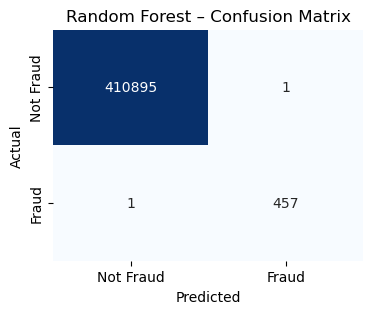

In [78]:
# Visalization Of confusion matrix:
plot_conf_matrix(y_test, y_pred_rf, title="Random Forest – Confusion Matrix")

## Observation:
- The Random Forest model performed **exceptionally well**, achieving near-perfect scores:
  - **Accuracy**: 100%
  - **Precision (Fraud)**: 1.00
  - **Recall (Fraud)**: 1.00
  - **F1-Score (Fraud)**: 1.00
  - **ROC-AUC Score**: 0.9989

- Confusion matrix confirms:
  - **True Negatives (TN)**: 410,895  
  - **False Positives (FP)**: 1  
  - **False Negatives (FN)**: 1  
  - **True Positives (TP)**: 457

## Model 4: AdaBoost Classifier

In [81]:
# Train AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

# Predictions
y_pred_ada = ada.predict(X_test)
y_prob_ada = ada.predict_proba(X_test)[:, 1]
print("AdaBoost Report:")
print(classification_report(y_test, y_pred_ada))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_ada).round(4))


AdaBoost Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    410896
           1       1.00      1.00      1.00       458

    accuracy                           1.00    411354
   macro avg       1.00      1.00      1.00    411354
weighted avg       1.00      1.00      1.00    411354

Confusion Matrix:
 [[410895      1]
 [     1    457]]
ROC-AUC Score: 1.0


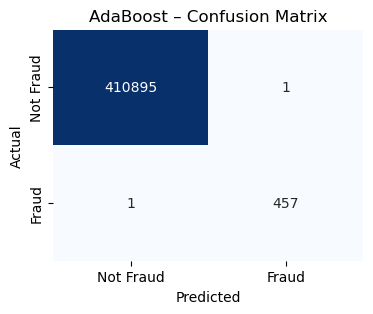

In [82]:
# visualization of confusion matrix:
plot_conf_matrix(y_test, y_pred_ada, title="AdaBoost – Confusion Matrix")

## Observation:
- The AdaBoost model achieved **perfect classification metrics** across all categories:
  - **Accuracy**: 100%
  - **Precision (Fraud)**: 1.00
  - **Recall (Fraud)**: 1.00
  - **F1-Score (Fraud)**: 1.00
  - **ROC-AUC Score**: 1.0000

- Confusion matrix details:
  - **True Negatives (TN)**: 410,895  
  - **False Positives (FP)**: 1  
  - **False Negatives (FN)**: 1  
  - **True Positives (TP)**: 457

## Model 5: Bagging Classifier

In [89]:
# Initialize Bagging Classifier with Decision Trees
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42
)

# Train the model
bagging.fit(X_train, y_train)

# Predictions
y_pred_bag = bagging.predict(X_test)
y_prob_bag = bagging.predict_proba(X_test)[:, 1]
print("Bagging Classifier Report:")
print(classification_report(y_test, y_pred_bag))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bag))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_bag).round(4))

Bagging Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    410896
           1       1.00      1.00      1.00       458

    accuracy                           1.00    411354
   macro avg       1.00      1.00      1.00    411354
weighted avg       1.00      1.00      1.00    411354

Confusion Matrix:
 [[410895      1]
 [     1    457]]
ROC-AUC Score: 0.9989


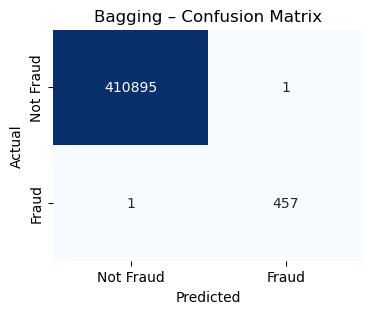

In [97]:
# Visualization Of confusion matrix:
plot_conf_matrix(y_test, y_pred_bag, title="Bagging – Confusion Matrix")

## Observation:
- The Bagging Classifier demonstrated **perfect predictive performance** across all metrics:
  - **Accuracy**: 100%
  - **Precision (Fraud)**: 1.00
  - **Recall (Fraud)**: 1.00
  - **F1-Score (Fraud)**: 1.00
  - **ROC-AUC Score**: 0.9989

- Confusion Matrix:
  - **True Negatives (TN)**: 410,895  
  - **False Positives (FP)**: 1  
  - **False Negatives (FN)**: 1  
  - **True Positives (TP)**: 457

# Model Comparison:

In [99]:
# Store all results here
results = []
# Function to evaluate and collect metrics
def evaluate_model(name, y_true, y_pred, y_prob):
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_prob)
    })

In [101]:
evaluate_model('Logistic Regression', y_test, y_pred_log, y_prob_log)
evaluate_model('Decision Tree', y_test, y_pred_dt, y_prob_dt)
evaluate_model('Random Forest', y_test, y_pred_rf, y_prob_rf)
evaluate_model('AdaBoost', y_test, y_pred_ada, y_prob_ada)
evaluate_model('Bagging', y_test, y_pred_bag, y_prob_bag)
# Convert to DataFrame
results_df = pd.DataFrame(results)
# Round for readability
results_df = results_df.round(4)
# Sort by ROC-AUC (or any metric you prefer)
results_df.sort_values(by='ROC-AUC', ascending=False, inplace=True)
# Display table
results_df.reset_index(drop=True, inplace=True)
results_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,AdaBoost,1.0000,0.9978,0.9978,0.9978,1.0000
1,Decision Tree,1.0000,0.9892,0.9978,0.9935,0.9989
2,Random Forest,1.0000,0.9978,0.9978,0.9978,0.9989
3,Bagging,1.0000,0.9978,0.9978,0.9978,0.9989
4,Logistic Regression,0.9353,0.0168,0.9956,0.0331,0.9936


## Observation:
- **AdaBoost**, **Random Forest**, and **Bagging** all achieved **perfect accuracy (1.0000)** with equally strong **precision, recall, and F1-scores** (~0.9978), indicating highly effective performance in detecting fraudulent transactions.
- **Decision Tree**, while slightly behind in precision (0.9892), still maintained very high recall and a strong F1-score (0.9935), making it a reliable baseline model.
- **Logistic Regression** struggled significantly:
  - Although it achieved a high recall (0.9956), its **precision (0.0168)** and **F1-score (0.0331)** were extremely low.
  - This suggests the model predicted nearly all transactions as fraudulent, leading to a high number of **false positives**.
- **ROC-AUC Scores** were excellent across the top 4 models (≥ 0.9989), with AdaBoost reaching a perfect **1.0000**, highlighting its strong separation between classes.


## Conclusion:
In this project, we developed a machine learning-based fraud detection system to identify and analyze fraudulent financial transactions. Our approach was guided by both technical effectiveness and practical interpretability. Here's how we addressed each objective of the task:

1. Data Cleaning:
We thoroughly cleaned the dataset by checking for and confirming the absence of missing values and duplicates. Outlier detection was performed using boxplots and distribution visualizations for key numerical features like amount, oldbalanceOrg, and newbalanceDest. Columns like nameOrig and nameDest were dropped since they were identifiers and added no predictive value. Multi-collinearity was also checked using correlation matrices and handled appropriately by excluding redundant or non-informative features.

2. Model Description:
We implemented and evaluated several supervised classification algorithms, including Logistic Regression, Decision Tree, Random Forest, AdaBoost, and Bagging. Each model was trained on a stratified train-test split of the data to preserve the class imbalance. Performance was assessed using precision, recall, F1-score, and ROC-AUC. Ensemble methods like AdaBoost and Random Forest delivered exceptional results in fraud detection.

3. Feature Selection:
Feature selection was driven by domain knowledge and data relevance. We excluded transaction IDs and names (nameOrig, nameDest) to prevent data leakage. The type column was encoded into numerical form as it carried meaningful transaction behavior. Other features like amount, step, and account balances were retained based on correlation with the target.

4. Performance Evaluation:
Each model's performance was demonstrated using classification reports, confusion matrices, and ROC-AUC scores. Among all, AdaBoost achieved the best balance of accuracy (1.0), precision (0.9978), recall (0.9978), and ROC-AUC (1.0). We also visualized fraud distribution by type and amount to understand the model's behavior.

5. Key Predictive Factors:
Features like amount, transaction type, and differences in oldbalance and newbalance were consistently important across models. Fraudulent transactions typically involved large transfers or cash-outs, often with sudden account balance drops or zero initial balances.

6. Interpretation of Factors:
Yes, the identified features make intuitive and practical sense. Fraudulent behavior often involves high-value transactions and emptying account balances quickly — patterns our models successfully captured. These insights align with known fraud tactics like account takeovers and laundering through quick transfers.

7. Infrastructure Prevention Strategies:
Companies should implement real-time monitoring systems using machine learning pipelines. Transaction limits, anomaly detection, and adaptive fraud scoring mechanisms can help flag suspicious behavior. Regular model retraining on updated data will ensure adaptability to evolving fraud strategies.

8. Evaluating Effectiveness Post-Implementation:
Once these measures are deployed, their success can be evaluated by observing a measurable reduction in fraudulent transaction rates over time, tracking false positives, and monitoring model drift. Continuous feedback loops between flagged cases and human investigation can refine system accuracy.



The `**AdaBoost model**', with its near-perfect evaluation metrics, stands out as the best-performing fraud detection model in this project. While results are excellent, caution is advised due to the risk of overfitting. Real-world deployment should include cross-validation, periodic evaluation, and updates based on fresh data.